In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [3]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [5]:
m_D0 = 1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 1e-3*Particle.from_string('D*+').mass
print m_Dst
m_pi = 1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
mD* - mD0 = 0.14543


In [6]:
def drawOnCMSCanvas(dobj, opt = None, tag=''):
    c = rt.TCanvas('c'+tag, 'c'+tag, 50, 50, 800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    
    if dobj.__class__ == rt.RooPlot:
        dobj.Draw()
    elif dobj[0].__class__ in [rt.TH1D, rt.TH2D]:
        for i, o in enumerate(dobj):
            do = ''
            if not (opt is None):
                if opt == 'same':
                    if i>0:
                        do = 'SAME'
                else:
                    do = opt[i]
            o.Draw(do)
    else:
        print 'Class not recognized'
        raise
        
    
    CMS_lumi.CMS_lumi(c, -1, 0)
    c.obj = dobj
    c.Draw()
    return c

In [7]:
def extarct(t, branches = []):
    if len(branches) == 0:
        branches = t.keys()
    l = {}
    for k in branches:
        print 'Loading branch', k
        m = []
        for i, e in enumerate(t.array(k)):
            m += list(e)
        l[k] = np.array(m)
    
    return l

In [8]:
def extarct_multiple(fname, branches = []):
    if len(branches) == 0:
        print 'Must give a branches list'
    l = {}
    for b in branches:
        l[b] = []
    
    flist = glob(fname)
    
    for i,f in enumerate(flist):
        t = ur.open(f)
        if 'outA;1' in t.keys():
            t=t['outA']['Tevts']
            for k in branches:
                
                for i, e in enumerate(t.array(k)):
                    l[k] += list(e)
    
    for b in branches:
        l[b] = np.array(l[b])
    return l

In [9]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [10]:
isinstance(4.3, float)

True

In [11]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/MuDst_candidates.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()[9:]
for b in np.sort(branches):
    print b

['n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'chi2_D0pis', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_kpi', 'sigd_vtxD0pis_vtxMu', 'sigd_vtxkpi_vtxMu', 'sigdca_D0pis_vtxMu', 'sigdca_kpi_vtxMu'] 


chi2_D0pis
chi2_kpi
cos_D0pis_vtxMu
cos_kpi_vtxMu
d_vtxD0pis_vtxMu
d_vtxkpi_vtxMu
dca_D0pis_vtxMu
dca_kpi_vtxMu
mass_D0pis
mass_kpi
sigd_vtxD0pis_vtxMu
sigd_vtxkpi_vtxMu
sigdca_D0pis_vtxMu
sigdca_kpi_vtxMu


In [12]:
fn = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/MuDst_candidates/out*.root'
dMC = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC['mass_kpi'].shape[0]

Number of candidates: 26408


In [13]:
fn = '../data/cmsRD/Run2018D/MuDst_candidates/out*.root'
dRD = extarct_multiple(fn, branches)
print 'Number of candidates:', dRD['mass_kpi'].shape[0]

Number of candidates: 243974


# Cuts declaration

In [14]:
cut = {}
cut['cos_D0pis_vtxMu'] = ['>', 0.95]
cut['chi2_D0pis'] = ['<', 3.84]
# cut['d_vtxkpi_vtxMu'] = ['>', 0.03]
# cut['sigdca_kpi_vtxMu'] = ['>', 2.]

In [15]:
np.max(dRD['chi2_D0pis'])

6.63449

In [16]:
sps.chi2.cdf(3.84, 1)

0.9499564787512949

In [17]:
def createSel(d, cut):
    sel = np.ones_like(d[cut.keys[0]], dtype=bool)
    for k, v in cut.iteritems():
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
    return sel

## MC only

In [18]:
dMC['mass_D0pis']

array([3.4751408, 2.1315246, 2.320639 , ..., 2.1600392, 2.0108001,
       2.1057537], dtype=float32)

<ROOT.TLine object ("TLine") at 0x7fefbb159a40>

 FCN=6.94837 FROM MIGRAD    STATUS=CONVERGED     277 CALLS         278 TOTAL
                     EDM=1.37362e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.43700e+02   1.54587e+01   1.00704e-02  -5.23939e-05
   2  p1           6.89066e+02   1.84119e+01   2.44778e-02  -1.45725e-05
   3  p2           2.01034e+00   1.02105e-05   9.58602e-07  -1.24184e+01
   4  p3           4.58179e-04   1.87756e-05   1.36319e-08  -4.60438e+01
                               ERR DEF= 0.5


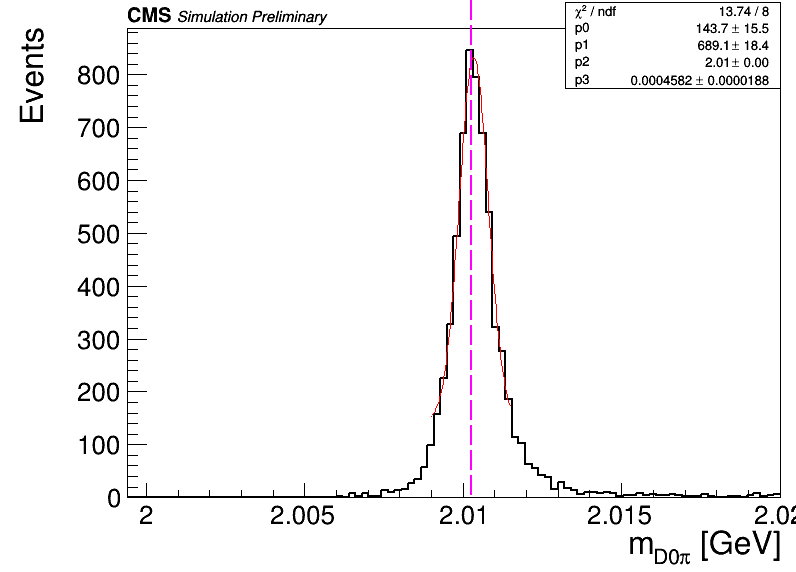

In [19]:
h = create_TH1D(dMC['mass_D0pis'], axis_title=['m_{D0#pi} [GeV]', 'Events'], binning=[100,m_D0+m_pi-0.005,2.02])
ffit = rt.TF1('ffit', '[0]+[1]*TMath::Gaus(x,[2],[3])', 2.009, 2.0115)
ffit.SetParameters(1,100,2.01,0.001)
r = h.Fit(ffit, 'LSR')
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h])
cl.DrawLine(m_Dst, 0, m_Dst, 1800)

Tot histo entries: 6463
[WARNING] Chi2: 403.438409756 / 94
Total: Nsig = 5857, Nbkg = 589
Sig region histo entries: 6133
Sig region: Nsig = 5841, Nbkg = 292



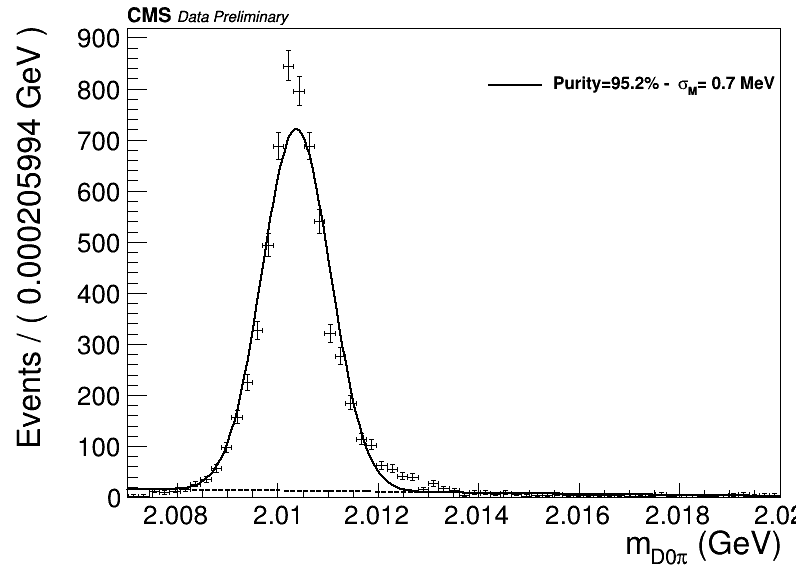

In [35]:
binning = [50,2.007,2.02]
m = rt.RooRealVar('m', 'm_{D0#pi}', binning[1], binning[2], 'GeV')
frame = m.frame(rf.Title(""))

h.Sumw2()

print 'Tot histo entries: {:.0f}'.format(h.Integral(1, h.binning[0]))

mean = rt.RooRealVar('mean', 'm_{D0}', m_Dst, 0, 5, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.0007, 0.00005, 0.05, 'GeV') 
pdf_sig = rt.RooGaussian('gaus','sig pdf', m, mean, sigma)

nsig = rt.RooRealVar('nsig', 'N_{S}', 3000, 0, 1e6)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

#         lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
#         pdf_bkg = rt.RooExponential('expo', 'bkg pdf', m, lam)
a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
# a2 = rt.RooRealVar('a2', 'a2', -0.1, -100, 1000)
pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', m, rt.RooArgList(a0, a1), 0)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0, 1e6)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

data = rt.RooDataHist('d', 'd', rt.RooArgList(m), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
pdf_tot.fitTo(data, rt.RooFit.PrintLevel(-1))

chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
if chi2.getVal() > rt.TMath.ChisquareQuantile(0.95, h.binning[0]-1-5):
    print '[WARNING] Chi2:', chi2.getVal(), '/', h.binning[0]-1-5

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(1), rf.LineColor(1))
pdf_tot.plotOn(frame, rf.LineColor(1), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(1), rf.LineWidth(2), rf.LineStyle(7))

lb = mean.getVal()-3*sigma.getVal()
hb = mean.getVal()+3*sigma.getVal()
print 'Sig region histo entries: {:.0f}'.format(h.Integral(h.FindBin(lb), h.FindBin(hb)))


Nsig = erf(3/np.sqrt(2)) * nsig.getVal()
Nbkg = h.Integral(h.FindBin(lb), h.FindBin(hb)) - Nsig
print 'Sig region: Nsig = {:.0f}, Nbkg = {:.0f}\n'.format(Nsig, Nbkg)


purity = Nsig/float(Nbkg+Nsig)

CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(frame)
# mD0_avg = np.mean(sig_mean)
# resD0_avg = np.mean(sig_sigma)
# cl.DrawLine(mD0_avg-3*resD0_avg, 0, mD0_avg-3*resD0_avg, h.GetMaximum())
# cl.DrawLine(mD0_avg+3*resD0_avg, 0, mD0_avg+3*resD0_avg, h.GetMaximum())

leg = rt.TLegend(0.6,0.75,0.98,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h, 'Purity={:.1f}% - #sigma_{{M}}= {:.1f} MeV'.format(purity*100, 1e3*sigma.getVal()), 'l')
leg.Draw()
# c.SetLogy()

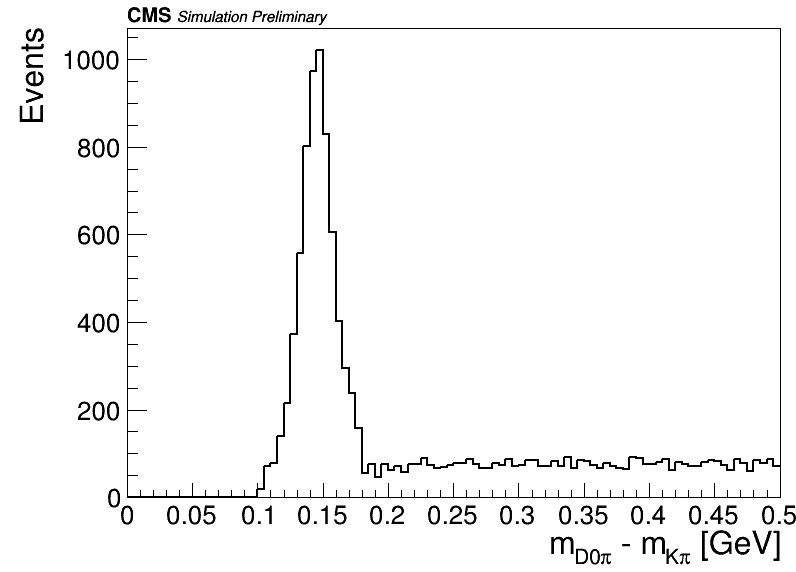

In [19]:
h = create_TH1D(dMC['mass_D0pis']-dMC['mass_kpi'], axis_title=['m_{D0#pi} - m_{K#pi} [GeV]', 'Events'], binning=[100,0.,.5])
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h])

<ROOT.TLine object ("TLine") at 0x7f8b1a0593f0>

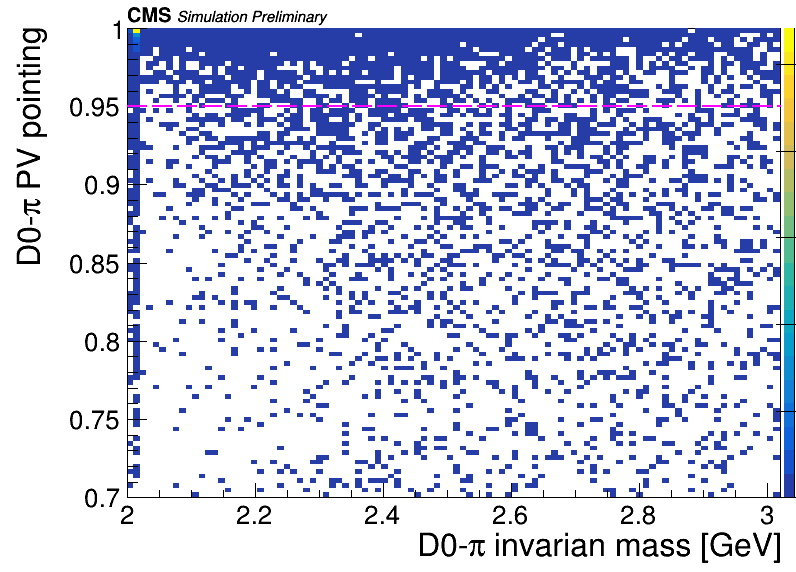

In [20]:
h = create_TH2D(np.column_stack((dMC['mass_D0pis'], dMC['cos_D0pis_vtxMu'])), 
                axis_title=['D0-#pi invarian mass [GeV]', 'D0-#pi PV pointing', ''],
                binning=[100,m_D0+m_pi-0.005,3.02, 100, 0.7, 1]
               )
c = drawOnCMSCanvas([h], ['colz'])
cl.DrawLine(h.binning[1], cut['cos_D0pis_vtxMu'][1], h.binning[2], cut['cos_D0pis_vtxMu'][1])
# c.SetLogy()
# c.SaveAs('../fig/1904_1/MC_kpi_MvsChi2.png')

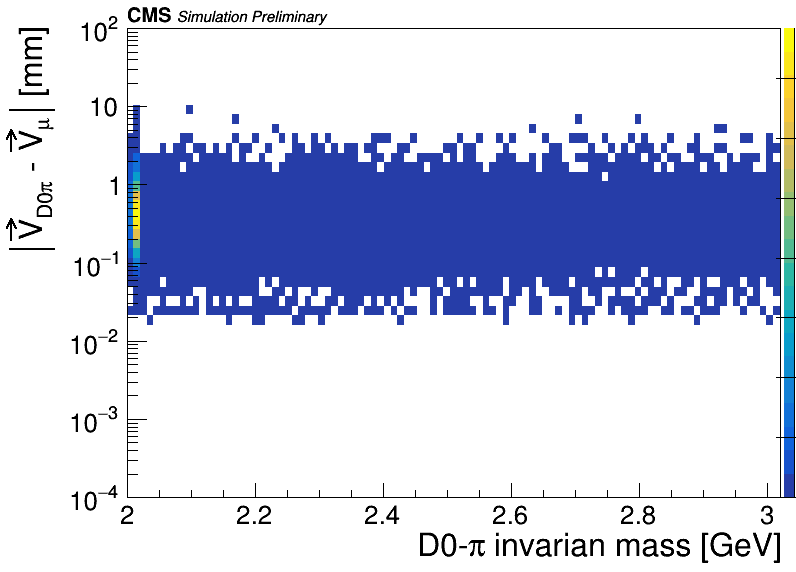

In [21]:
h = create_TH2D(np.column_stack((dMC['mass_kpi'], dMC['d_vtxkpi_vtxMu'])), 
                axis_title=['K-#pi invarian mass [GeV]', '#left|#vec{V}_{K#pi} - #vec{V}_{#mu}#right| [mm]', ''],
                binning=[np.linspace(0.6,3, num=100), np.logspace(-4, 2, num=50)]
               )
c = drawOnCMSCanvas([h], ['colz'])
c.SetLogy()

h = create_TH2D(np.column_stack((dMC['mass_D0pis'], dMC['d_vtxkpi_vtxMu'])), 
                axis_title=['D0-#pi invarian mass [GeV]', '#left|#vec{V}_{D0#pi} - #vec{V}_{#mu}#right| [mm]', ''],
                binning=[np.linspace(m_D0+m_pi-0.005,3.02, num=100), np.logspace(-4, 2, num=50)]
               )
c = drawOnCMSCanvas([h], ['colz'])
c.SetLogy()
# cl.DrawLine(h.binning[0][0], cut['d_vtxkpi_vtxMu'], h.binning[0][-1], cut['d_vtxkpi_vtxMu'])

## RD only

Chi2 cut eff: 0.8819751284972989


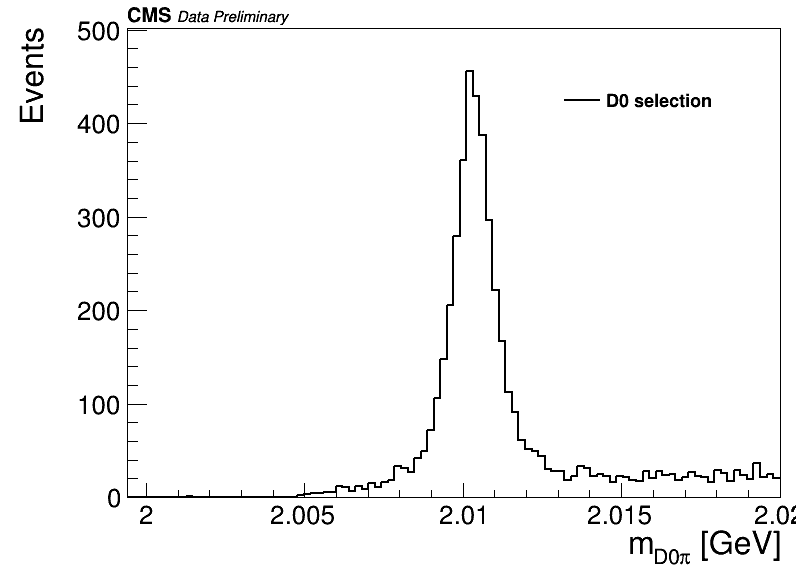

In [26]:
leg = rt.TLegend(0.7,0.7,0.95,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

hl = []
lsel = []

# sel = np.ones_like(dRD['mass_D0pis'], dtype=bool)
sel = dRD['chi2_D0pis'] < cut['chi2_D0pis'][1]
print 'Chi2 cut eff:', np.sum(sel)/float(sel.shape[0])
h = create_TH1D(dRD['mass_D0pis'][sel], axis_title=['m_{D0#pi} [GeV]', 'Events'], binning=[100,m_D0+m_pi-0.005,2.02])
leg.AddEntry(h, 'D0 selection', 'l')
hl.append(h)
lsel.append(sel)

# sel = np.logical_and(sel, dRD['cos_D0pis_vtxMu'] > cut['cos_D0pis_vtxMu'][1])
# hcut = create_TH1D(dRD['mass_D0pis'][sel], binning=h.binning)
# leg.AddEntry(hcut, '& vtx pointing > {:.2f}'.format(cut['cos_D0pis_vtxMu'][1]), 'l')
# hcut.SetLineColor(2)
# hl.append(hcut)
# lsel.append(sel)

CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(hl, 'same')
hl[0].GetYaxis().SetRangeUser(0, hl[0].GetMaximum()*1.1)
leg.Draw()

Tot histo entries: 4638
[WARNING] Chi2: 174.695863464 / 94
Total: Nsig = 3115, Nbkg = 1525
Sig region histo entries: 3625
Sig region: Nsig = 3106, Nbkg = 519



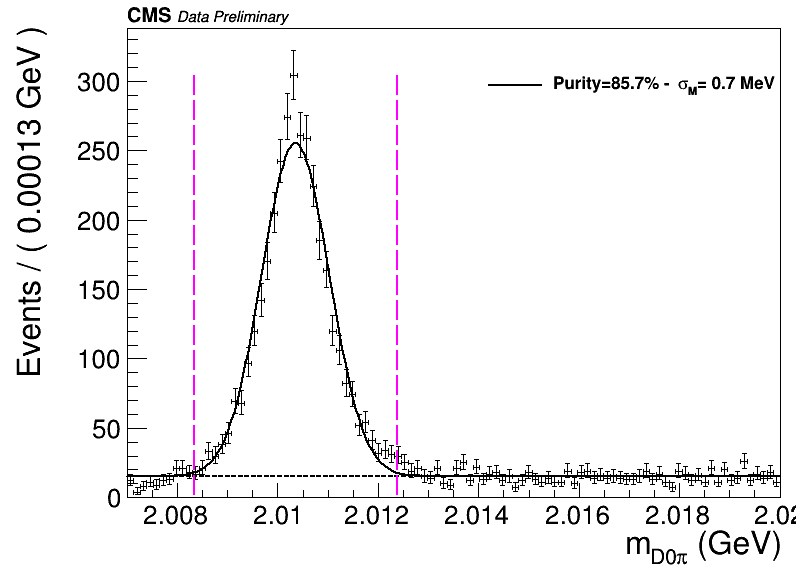

In [32]:
pk_width = 0.04
fit_stop = 0.06

leg = rt.TLegend(0.6,0.75,0.98,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

useRooFit = True

dobj = []
N_sig = []
purity = []

sig_mean = []
sig_sigma = []

binning = [100,2.007,2.02]
m = rt.RooRealVar('m', 'm_{D0#pi}', binning[1], binning[2], 'GeV')
frame = m.frame(rf.Title(""))

for i, h in enumerate(hl):
    h = create_TH1D(dRD['mass_D0pis'][lsel[i]], binning=binning)
    h.SetLineColor(hl[i].GetLineColor())
    h.Sumw2()
    dobj.append(h)
    
    print 'Tot histo entries: {:.0f}'.format(h.Integral(1, h.binning[0]))
    
    if(useRooFit):
        mean = rt.RooRealVar('mean', 'm_{D0}', m_Dst, 0, 5, 'GeV')
        sigma = rt.RooRealVar('sigma', '#sigma', 0.001, 0.00005, 0.05, 'GeV') 
        pdf_sig = rt.RooGaussian('gaus','sig pdf', m, mean, sigma)
        
        nsig = rt.RooRealVar('nsig', 'N_{S}', 3000, 0, 1e6)
        pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)
        
#         lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
#         pdf_bkg = rt.RooExponential('expo', 'bkg pdf', m, lam)
        a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
        a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
        a2 = rt.RooRealVar('a2', 'a2', -0.1, -100, 1000)
        pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', m, rt.RooArgList(a0, a1, a2), 0)
        
        nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0, 1e6)
        pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)
        
        data = rt.RooDataHist('d', 'd', rt.RooArgList(m), h)

        pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
        pdf_tot.fitTo(data, rt.RooFit.PrintLevel(-1))
        
        chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
        if chi2.getVal() > rt.TMath.ChisquareQuantile(0.95, h.binning[0]-1-5):
            print '[WARNING] Chi2:', chi2.getVal(), '/', h.binning[0]-1-5
            
        print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

        data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(hl[i].GetLineColor()), rf.LineColor(hl[i].GetLineColor()))
        pdf_tot.plotOn(frame, rf.LineColor(hl[i].GetLineColor()), rf.LineWidth(2))
        pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(hl[i].GetLineColor()), rf.LineWidth(2), rf.LineStyle(7))
        
        lb = mean.getVal()-3*sigma.getVal()
        hb = mean.getVal()+3*sigma.getVal()
        print 'Sig region histo entries: {:.0f}'.format(h.Integral(h.FindBin(lb), h.FindBin(hb)))

        
        Nsig = erf(3/np.sqrt(2)) * nsig.getVal()
        Nbkg = h.Integral(h.FindBin(lb), h.FindBin(hb)) - Nsig
        print 'Sig region: Nsig = {:.0f}, Nbkg = {:.0f}\n'.format(Nsig, Nbkg)
        
        N_sig.append(Nsig)
        purity.append(Nsig/float(Nbkg+Nsig))
        
        sig_mean.append(mean.getVal())
        sig_sigma.append(sigma.getVal())
        
        leg.AddEntry(h, 'Purity={:.1f}% - #sigma_{{M}}= {:.1f} MeV'.format(purity[-1]*100, 1e3*sigma.getVal()), 'l')

    else:
        if i == 0:
            fun = 'expo'
        else:
            fun = 'expo'

        f = rt.TF1('bkg', fun, h.binning[1], h.binning[2])
        f.SetLineColor(hl[i].GetLineColor())
        f.SetLineStyle(9)
        r = h.Fit(f, 'LSNQ', '', h.binning[1], m_D0-fit_stop).Get()
        if r.Prob() < 0.05:
            print '[WARNING]: Bad fit fot histo N', i
        dobj.append(f)

        n_start = h.FindBin(m_D0-pk_width)
        n_stop = h.FindBin(m_D0+pk_width)

        Nsig = 0
        Ntot = 0
        for n in range(n_start, n_stop+1):
            Nsig += h.GetBinContent(n) - f.Eval(h.GetBinCenter(n))
            Ntot += h.GetBinContent(n)
        N_sig.append(Nsig)
        purity.append(Nsig/Ntot)
        leg.AddEntry(h, '#varepsilon={:.1f}% - Purity={:.1f}%'.format(100*Nsig/N_sig[0], purity[-1]*100), 'l')


if useRooFit:
    CMS_lumi.extraText = "     Data Preliminary"
    c = drawOnCMSCanvas(frame)
    mD0_avg = np.mean(sig_mean)
    resD0_avg = np.mean(sig_sigma)
    cl.DrawLine(mD0_avg-3*resD0_avg, 0, mD0_avg-3*resD0_avg, dobj[0].GetMaximum())
    cl.DrawLine(mD0_avg+3*resD0_avg, 0, mD0_avg+3*resD0_avg, dobj[0].GetMaximum())
else:
    hmax = np.max([h.GetMaximum() if i%2 == 0 else 0 for i,h in enumerate(dobj)])
    hmin = np.min([h.GetMinimum() if i%2 == 0 else 1e10 for i,h in enumerate(dobj)])
    dobj[0].GetYaxis().SetRangeUser(hmin, 1.*hmax)
    c = drawOnCMSCanvas(dobj, ['SAME']*len(dobj))
    cl.DrawLine(m_D0-pk_width, hmin, m_D0-pk_width, hmax)
    cl.DrawLine(m_D0+pk_width, hmin, m_D0+pk_width, hmax)
    cl.SetLineColor(5)
    cl.DrawLine(m_D0-fit_stop, hmin, m_D0-fit_stop, hmax)
    cl.DrawLine(m_D0+fit_stop, hmin, m_D0+fit_stop, hmax)
    cl.SetLineColor(6)
leg.Draw()
# c.SetLogy()

In [ ]:
h = create_TH1D(dRD['mass_D0pis']-dRD['mass_kpi'], axis_title=['m_{D0#pi} - m_{K#pi} [GeV]', 'Events'], binning=[100,0.,.5])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas([h])